## 数据预处理

In [13]:
import pandas as pd
from random import shuffle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
corpus_data = pd.read_csv( "./data/corpus.tsv", sep="\t", names=["gid", "gname"])
print(f"商品标题corpus_data = {corpus_data.shape}")
train_data = pd.read_csv("./data/train.query.txt", sep="\t", names=["qid", "query"])
print(f"用户查询train_data = {train_data.shape}")
qrels = pd.read_csv("./data/qrels.train.tsv", sep="\t", names=["qid", "gid"])
print(f"查询与商品点击关系qrels = {qrels.shape}")
test_data = pd.read_csv("./data/dev.query.txt", sep="\t", names=["qid", "query"])
print(f"用户查询test_data = {test_data.shape}")

corpus_data = corpus_data.set_index("gid")
train_data = train_data.set_index("qid")
qrels = qrels.set_index("qid")
test_data = test_data.set_index("qid")
query2corpus = pd.DataFrame({"query":train_data.loc[qrels.index]['query'], "gname":corpus_data.loc[qrels.gid]['gname'].values})

商品标题corpus_data = (1001500, 2)
用户查询train_data = (100000, 2)
查询与商品点击关系qrels = (100000, 2)
用户查询test_data = (1000, 2)


In [ ]:
query2corpus.to_csv("./data/full_df.csv")

In [ ]:
X_train,X_val = train_test_split(query2corpus,test_size=0.01)

In [ ]:
X_train.to_csv("./data/X_train.csv")
X_val.to_csv("./data/X_val.csv")

In [ ]:
test_df = pd.read_csv("./data/X_train.csv")
test_df.shape

(99000, 2)

In [14]:
query2corpus.to_csv()

,query,gname
qid,,
1,美赞臣亲舒一段,领券满减】美赞臣安婴儿A+亲舒 婴儿奶粉1段850克 0-12个月宝宝
2,慱朗手动料理机,Braun/博朗 MQ3035/3000/5025料理棒手持小型婴儿辅食家用搅拌机
3,電力貓,小米WiFi电力猫无线路由器套装一对300M穿墙宝家用信号增强扩展器
4,掏夹缝工具,电梯地坎清洁工具除灰尘神器轿厢门槽缝隙掏勺维保打扫奥的斯三菱
5,飞推vip,飞逗推拍 店主邀请码 去水印 创意视频一键制作视频
...,...,...
99996,新娘手饰品,独家原创高端多色婚礼手腕花伴娘姐妹手花 新娘结婚腕花 绑带配盒
99997,一吨铲车,小型铲车装载机四驱养殖场小铲车工程农用推土机电动单缸小装载机
99998,避風塘蟹香蒜酥,十味观避风塘蟹香蒜酥/潮汕沙茶酱/XO酱美食推荐数量有限台湾直邮


In [5]:
test_data

,query
qid,
200001,甲黄酸阿怕替尼片
200002,索泰zbox
200003,kfc游戏机
200004,bunny成兔粮
200005,铁线威灵仙
...,...
200996,液压煎孑
200997,友鱼水水族
200998,玻璃水帘


In [6]:
train_data

,query
qid,
1,美赞臣亲舒一段
2,慱朗手动料理机
3,電力貓
4,掏夹缝工具
5,飞推vip
...,...
99996,新娘手饰品
99997,一吨铲车
99998,避風塘蟹香蒜酥


## 数据分析

In [50]:
# 将所有文本分词，然后存储起来
import math
import jieba
from collections import Counter
from tqdm import tqdm
import pandas as pd
corpus_data = pd.read_csv("./data/simple_corpus.csv")
sentences = []
word_set = set()
temp = corpus_data.head(10).copy()
for row in tqdm(temp.gname.values.tolist()):
    seg_list = list(jieba.cut(row, cut_all=False))
    # sentence = " ".join([seg for seg in seg_list if seg != '' and seg != "\n" and seg != "\n\n"])
    sentences.append(seg_list)
    word_set.update(set(seg_list))

100%|██████████| 10/10 [00:00<00:00, 4198.08it/s]


In [5]:
import math
import jieba
from collections import Counter
from tqdm import tqdm
import pandas as pd
corpus_data = pd.read_csv("./data/simple_full_query_corpus_pairs.csv")

In [6]:
# tf idf
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
sentences = []
word_set = set()
temp = corpus_data.head(10000).copy()
for row in tqdm(temp.gname.values.tolist()):
    seg_list = list(jieba.cut(row, cut_all=False))
    # sentence = " ".join([seg for seg in seg_list if seg != '' and seg != "\n" and seg != "\n\n"])
    sentences.append(seg_list)
    word_set.update(set(seg_list))
concat_sentences = [" ".join(sent) for sent in sentences]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(concat_sentences)
word_array = np.array(vectorizer.get_feature_names()) #所有文本的关键字
weights = X.toarray()              #对应的tfidf矩阵
# 抽取weight前n的词
# n = 10
# top_word_idx = np.argpartition(weight, -n, axis=1)[:,-n:]
ratio = 0.7
tf_idf_query = []
drop_words = []
for i in tqdm(range(len(weights))):
    weight = weights[i]
    sentence = sentences[i]
    mask_w = weight[np.nonzero(weight)]
    mask_word = word_array[np.nonzero(weight)]
    score_rank = sorted(mask_w)
    drop_cnt = int((1-ratio)*len(score_rank))
    threshold = score_rank[drop_cnt]
    chosen_ids = np.where(weight>=threshold)[0]
    chosen_words = word_array[chosen_ids]
    drop_word = word_array[np.where((weight<threshold) & (weight>0))[0]]
    # print(f"drop {drop_word}")
    # print(f"chosen word {chosen_words}")
    # print(mask_word)
    # print(sentence)
    assert len(chosen_ids)+len(drop_word) == len(mask_w), f"{len(chosen_ids)},{drop_cnt},{len(mask_w)}"
    tf_idf_query.append([word for word in sentence if word.lower() in chosen_words])
    drop_words.append(drop_word)
# print(fake_query)
temp[f"TF-IDF-{ratio}"] = ["".join(ws) for ws in tf_idf_query]
temp[f"drop"] = ["".join(ws) for ws in drop_words]
# def f(x):
#     L = len(x.gname)
#     cut_at = min(L//2,10)
#     return x.gname[:cut_at]
# temp['fake_query_former10'] = temp.apply(f,axis=1)
# temp[f'fake_query_former4word'] = ["".join(sent[:4]) for sent in sentences]
# temp['fake_query_former2word+TF-IDF-2'] = ["".join(list(dict.fromkeys(sent[:4]+tfidf[:2]))) for sent,tfidf in zip(sentences,tf_idf_query)]
with pd.option_context('display.max_rows', None):
    display(temp.head(1000))


100%|██████████| 10000/10000 [00:01<00:00, 5582.03it/s]
/Users/bytedance/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 10000/10000 [00:06<00:00, 1456.10it/s]


,query,gname,TF-IDF-0.7,drop
0,美赞臣亲舒一段,领券满减】美赞臣安婴儿A+亲舒 婴儿奶粉1段850克 0-12个月宝宝,领券满减美赞臣婴儿亲舒婴儿奶粉850,12宝宝
1,慱朗手动料理机,Braun/博朗 MQ3035/3000/5025料理棒手持小型婴儿辅食家用搅拌机,Braun博朗MQ303530005025料理手持辅食搅拌机,婴儿家用小型
2,电力猫,小米WiFi电力猫无线路由器套装一对300M穿墙宝家用信号增强扩展器,小米WiFi电力路由器一对300M穿墙信号增强扩展器,套装家用无线
3,掏夹缝工具,电梯地坎清洁工具除灰尘神器轿厢门槽缝隙掏勺维保打扫奥的斯三菱,地坎灰尘轿厢门槽缝隙掏勺维保打扫奥的斯三菱,工具清洁电梯神器
4,飞推vip,飞逗推拍 店主邀请码 去水印 创意视频一键制作视频,飞逗推拍店主邀请水印视频一键视频,创意制作
5,多功能托地把,免手洗拖把家用一拖净刮刮乐干湿两用懒人拖平板墩布托帕拖地神器,免手拖把一拖刮乐干湿两用平板布托拖地,家用懒人神器
6,充气浮力袖,学游泳神器装备充气腰背漂水袖浮臂三角浮力儿童游泳辅助工具大人,游泳充气腰背水袖浮臂三角浮力游泳辅助工具大人,儿童神器装备
7,盒马花胶鸡汤锅,盒马鲜生工坊代购 花胶奶冻150g 入口Q弹 奶味浓郁 香甜丝滑,盒马鲜生工坊花胶奶冻入口奶味浓郁丝滑,150g代购香甜
8,塞塞乐,婴儿童玩具6个月以上8宝宝益智早教0一1岁男孩女孩六9月十7新生礼,儿童玩具以上早教男孩女孩新生,宝宝益智
9,广汽传祺gs5挡风遮雨条子,2021款广汽传祺GS5晴雨挡遮雨板传奇GS5配件车窗雨眉防雨条挡雨板,款广汽传祺GS5晴雨挡遮雨传奇GS5车窗雨眉挡雨板,2021配件防雨


In [ ]:
# 分析idf
import math
def idf(word, count_list):
    n_contain = sum([1 for count in count_list if word in count])
    return math.log(len(count_list) / (1 + n_contain))

count_list = list()
for i in range(len(sentences)):
    count = Counter(sentences[i])
    count_list.append(count)
w2idf = {}
for w in word_set:
    w2idf[w] = idf(w,count_list)
sorted_keys = sorted(w2idf.keys(),key=lambda x:w2idf[x])
df = pd.DataFrame(w2idf.items(),columns=["word","IDF"]).sort_values(by="IDF")
# with pd.option_context('display.max_rows', None):
#     display(df)

## 停用词

In [21]:
import pandas as pd
full_df = pd.read_csv('./data/simple_full_query_corpus_pairs.csv')
stop_words = ['舒适','高级','高端','气质','大气','专业','时尚','宽松','专用','通用','可爱',\
    '适用','百搭','优质','洋气','简约','实惠','特惠','潮流','家用','男女',\
    '新款','正品','包邮','现货','正版','专柜','新品','网红','官方','旗舰店']

In [24]:
from collections import defaultdict
key2query = defaultdict(list)
cnt = Counter()
for row in tqdm(full_df['query'].values.tolist()):
    for k in stop_words:
        if k in row:
            # print(f"{k} in {row}")
            cnt[k]+=1
            key2query[k].append(row)
# print(cnt)
# print(key2query)

100%|██████████| 100000/100000 [00:00<00:00, 390846.25it/s]


<AxesSubplot:ylabel='Count'>

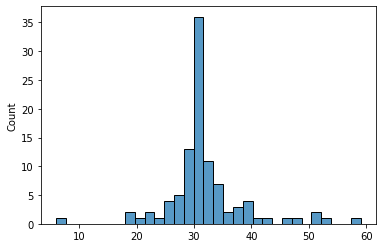

In [30]:
import seaborn as sns
sns.histplot([len(i) for i in temp.gname.values])

<AxesSubplot:ylabel='Count'>

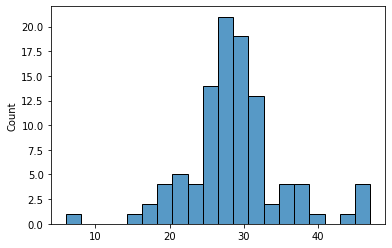

In [31]:
import seaborn as sns
sns.histplot([len(i) for i in temp.remove_dups_res.values])

In [49]:
# tf idf
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
sentences = []
stop_words = set(stop_words)
temp = pd.read_csv("./data/simple_corpus.csv")
for row in tqdm(temp.gname.values.tolist()):
    seg_list = list(jieba.cut(row, cut_all=False))
    sentences.append(seg_list)
    word_set.update(set(seg_list))
concat_sentences = [" ".join(sent) for sent in sentences]

drop_stop_words_res = []
remove_dups_res = []
dupeds = []
stopeds = []
dups_cnt = Counter()
stop_cnt = Counter()
for i in tqdm(range(len(concat_sentences))):
    used_word = set()
    sentence = sentences[i]
    drop_stop_words = []
    remove_dups = []
    stoped = []
    duped = []
    for w in sentence:
        if w not in stop_words:
            drop_stop_words.append(w)
            if w not in used_word:
                remove_dups.append(w)
                used_word.add(w)
            elif re.match(r'[\u4e00-\u9fa5]+',w):
                dups_cnt[w]+=1
                duped.append(w)
        else:
            stop_cnt[w]+=1
            stoped.append(w)
    
    drop_stop_words_res.append(drop_stop_words)
    remove_dups_res.append(remove_dups)
    dupeds.append(duped)
    stopeds.append(stoped)
temp[f"drop_stop_words_res"] = ["".join(ws) for ws in drop_stop_words_res]
temp[f"remove_dups_res"] = ["".join(ws) for ws in remove_dups_res]
# temp[f"dupeds"] = ["|".join(ws) for ws in dupeds]
# temp[f"stopeds"] = ["|".join(ws) for ws in stopeds]
# with pd.option_context('display.max_rows', None):
#     display(temp.head(10))
temp[["remove_dups_res"]].rename(columns={"remove_dups_res":"gname"}).to_csv("./data/simple_remove_dup_corpus.csv",index=False)



100%|██████████| 1001500/1001500 [00:14<00:00, 70217.36it/s]


In [55]:
# simple_remove_dup_X_train
pd.read_csv("./data/simple_X_train.csv")

,query,gname
0,冠宜春酒,冠宜春2000年44度山东省 怀旧陈年老酒库存陈酒收藏原创促销
1,威露士旗舰店官方旗舰,【会员专享】威露士9X除菌洗衣凝珠12g*32粒+袋装12g*20粒
2,相机视频传输,M0MA猛玛小玛400S Pro SDI无线图传高清HDMI单反摄像机视频传输
3,本工卡子,。木工卡子夹固定模具夹具夹紧器简易模具固定夹器木板固定架压紧
4,微生态,桌面鱼缸迷你微景观超白玻璃小鱼缸免换水办公桌过滤生态缸
...,...,...
98995,军用绑腿,【2条】军绿色老式复古全棉绑腿带 超宽9cm纯棉人字带 包邮
98996,宜兴鲜百合,2021现挖新鲜宜兴百合微苦5斤15个左右包邮食用土特产/非兰州甜百
98997,曲谱显示器,无线吉他动态乐谱显示器海量翻页器便携演奏脚踩翻谱器电吹管新品
98998,龙盘青花瓷,景德镇五龙青花龙纹瓷器大盘 60CM直径凶猛龙纹大陈设瓷盘


## 拼接fake query

In [ ]:
# 将所有文本分词，然后存储起来
import math
import jieba
from collections import Counter
from tqdm import tqdm
sentences = []
temp = query2corpus.copy()
for row in tqdm(temp.gname.values.tolist()):
    seg_list = list(jieba.cut(row, cut_all=False))
    # sentence = " ".join([seg for seg in seg_list if seg != '' and seg != "\n" and seg != "\n\n"])
    sentences.append(seg_list)
# with pd.option_context('display.max_rows', 100):
#     display(temp)


  0%|          | 0/100000 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/yp/fg1gg5v164gct6fcht35czvh0000gp/T/jieba.cache
Loading model cost 0.701 seconds.
Prefix dict has been built successfully.
100%|██████████| 100000/100000 [00:21<00:00, 4630.73it/s]


In [ ]:
temp.head(100)

,gname
query,
美赞臣亲舒一段,领券满减】美赞臣安婴儿A+亲舒 婴儿奶粉1段850克 0-12个月宝宝
慱朗手动料理机,Braun/博朗 MQ3035/3000/5025料理棒手持小型婴儿辅食家用搅拌机
電力貓,小米WiFi电力猫无线路由器套装一对300M穿墙宝家用信号增强扩展器
掏夹缝工具,电梯地坎清洁工具除灰尘神器轿厢门槽缝隙掏勺维保打扫奥的斯三菱
飞推vip,飞逗推拍 店主邀请码 去水印 创意视频一键制作视频
...,...
奥利奥玫瑰葡萄,亿滋奥利奥原味巧克力薄脆巧轻脆夹心小饼干冰淇淋官方旗舰店官网
菜刀菜板剪刀,砧板剪刀切菜剪子剪刀剪菜神器多功能切菜神器多用剪刀剪菜剪子
梅菜干,盛盛耳梅干菜100g梅干菜扣肉特产干货霉菜无沙


In [ ]:
temp['fake_query'] = ["".join(seg[:5]) for seg in sentences]

In [ ]:
temp

,gname,fake_query
query,,
美赞臣亲舒一段,领券满减】美赞臣安婴儿A+亲舒 婴儿奶粉1段850克 0-12个月宝宝,领券满减】美赞臣安
慱朗手动料理机,Braun/博朗 MQ3035/3000/5025料理棒手持小型婴儿辅食家用搅拌机,Braun/博朗 MQ3035
電力貓,小米WiFi电力猫无线路由器套装一对300M穿墙宝家用信号增强扩展器,小米WiFi电力猫无线
掏夹缝工具,电梯地坎清洁工具除灰尘神器轿厢门槽缝隙掏勺维保打扫奥的斯三菱,电梯地坎清洁工具除
飞推vip,飞逗推拍 店主邀请码 去水印 创意视频一键制作视频,飞逗推拍 店主邀请
...,...,...
新娘手饰品,独家原创高端多色婚礼手腕花伴娘姐妹手花 新娘结婚腕花 绑带配盒,独家原创高端多色婚礼
一吨铲车,小型铲车装载机四驱养殖场小铲车工程农用推土机电动单缸小装载机,小型铲车装载机四驱养殖场
避風塘蟹香蒜酥,十味观避风塘蟹香蒜酥/潮汕沙茶酱/XO酱美食推荐数量有限台湾直邮,十味观避风塘蟹香蒜酥


In [ ]:
temp.to_csv("./data/fake_train.csv",index=False)

In [ ]:
pd.read_csv("./data/fake_train.csv")

,query,gname
0,铂盛弹盖文艺,铂盛弹盖文艺保温杯学生男女情侣车载时尚英文锁扣不锈钢真空水杯
1,可爱虎子华为荣耀,可爱虎子华为荣耀X30i手机壳荣耀x30防摔全包镜头honorx30max液态硅胶虎年情侣女...
2,190色素色亚麻棉,190色素色亚麻棉平纹布料 衬衫裙服装定制手工绣花面料 汇典亚麻
3,松尼合金木工开孔器,松尼合金木工开孔器实木门开锁孔木板圆形打空神器定位打孔钻头
4,微钩绿蝴蝶材料,微钩绿蝴蝶材料包非成品 赠送视频组装教程 需自备钩针染料
...,...,...
1001495,专治牛皮癣特效中,专治牛皮癣特效中药膏专用药浴软膏银屑病老偏方泡澡沐浴露洗发水
1001496,梳妆台镜子遮挡帘,梳妆台镜子遮挡帘神器卫生间免打孔魔术贴拉帘轨道式防尘布帘滑轨
1001497,护目镜透明化工实验室,护目镜透明化工实验室防护眼镜农药防风烟雾打磨粉尘飞溅平光镜
1001498,克莱因蓝发带女,克莱因蓝发带女日常外戴秋冬百搭宽边运动头箍韩国网红头饰酷街头


<AxesSubplot:ylabel='Count'>

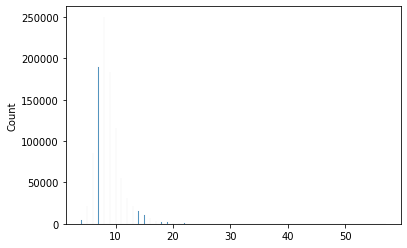

In [ ]:
import seaborn as sns
sns.histplot([len(i) for i in temp['fake_query_former4word'].values])

In [ ]:
corpus_data.to_csv("./data/corpus.csv",index=False)

In [ ]:
pd.concat(
    [
        corpus_data.rename(columns={'gname':'sentence'}),
        # train_data.rename(columns={'query':'sentence'}),
        # test_data.rename(columns={'query':'sentence'})
    ],
    ignore_index=True).to_csv("./data/full_corpus_querys.csv",index=False)

In [ ]:
pd.read_csv("./data/full_corpus_querys.csv")

,sentence
0,铂盛弹盖文艺保温杯学生男女情侣车载时尚英文锁扣不锈钢真空水杯
1,可爱虎子华为荣耀X30i手机壳荣耀x30防摔全包镜头honorx30max液态硅胶虎年情侣女...
2,190色素色亚麻棉平纹布料 衬衫裙服装定制手工绣花面料 汇典亚麻
3,松尼合金木工开孔器实木门开锁孔木板圆形打空神器定位打孔钻头
4,微钩绿蝴蝶材料包非成品 赠送视频组装教程 需自备钩针染料
...,...
1102495,液压煎孑
1102496,友鱼水水族
1102497,玻璃水帘
1102498,至关车载充电器qk789


<AxesSubplot:ylabel='Count'>

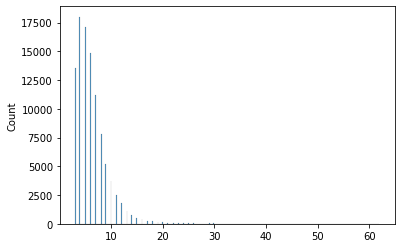

In [ ]:
import seaborn as sns
sns.histplot([len(i[0]) for i in train_data.values])

## 简繁转化

In [ ]:
from pyhanlp import *
import pandas as pd
from tqdm import tqdm
full_df = pd.read_csv("./data/full_query_corpus_pairs.csv")
fake_query2corpus = {}
for i in tqdm(range(len(full_df.head(100)))):
    row = full_df.iloc[i]
    q = row['query']
    q = HanLP.convertToSimplifiedChinese(q)
    c = row['gname']
    c = q = HanLP.convertToSimplifiedChinese(c)
    fake_query2corpus[q]=c
    # fake_querys = gen_synonyms(q,k=3)
    # for fq in fake_querys:
    #     fake_query2corpus[fq] = c
fake_query2corpus_df = pd.DataFrame(fake_query2corpus.items(),columns=["query","gname"])
fake_query2corpus_df
# full_df.to_csv("./data/auged_query2corpus.csv",index=False)

下载 https://file.hankcs.com/hanlp/hanlp-1.8.3-release.zip 到 /Users/bytedance/opt/miniconda3/envs/py38/lib/python3.8/site-packages/pyhanlp/static/hanlp-1.8.3-release.zip
100%   1.8 MiB  51.0 KiB/s ETA:  0 s [=========================================]
下载 https://file.hankcs.com/hanlp/data-for-1.7.5.zip 到 /Users/bytedance/opt/miniconda3/envs/py38/lib/python3.8/site-packages/pyhanlp/static/data-for-1.8.3.zip
 22% 637.7 MiB  69.0 KiB/s ETA:  2 h  2 m 34 s [======                         ]

下载失败 https://file.hankcs.com/hanlp/data-for-1.7.5.zip 由于 KeyboardInterrupt()
请参考 https://od.hankcs.com/book/intro_nlp/ 执行手动安装.
或手动下载 https://file.hankcs.com/hanlp/data-for-1.7.5.zip 到 /Users/bytedance/opt/miniconda3/envs/py38/lib/python3.8/site-packages/pyhanlp/static/data-for-1.8.3.zip


NameError: name 'exit' is not defined